# Part 2 - Exploratory Data Analysis and Feature Engineering/Selection

## Importing of Libraries


In [1]:
# importing sql libraries
import sqlite3

#importing libraries required for data analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

## Importing from SQLite db


In [2]:
#Connecting to nhgh_nonull database
sqliteConnection = sqlite3.connect('../data/nhgh_nonull.db')

#Querying from nhgh_nonull database
data_nonull = pd.read_sql(
    '''
    SELECT * FROM nhgh_nonull
    ''', 
    sqliteConnection
)

## Exploratory Data Analysis

### Distribution of the Population
<h4>Overall</h4>

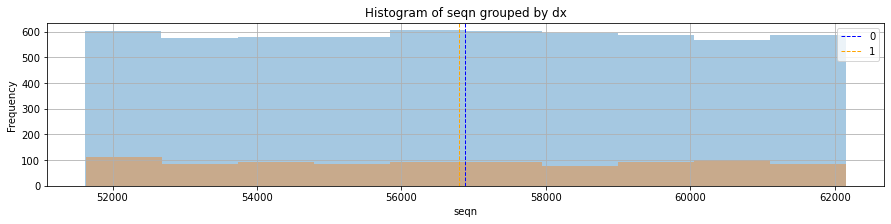

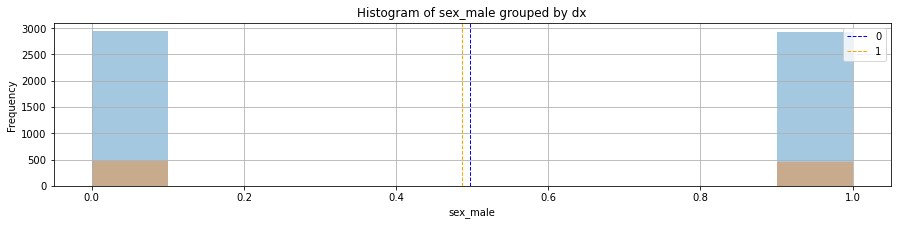

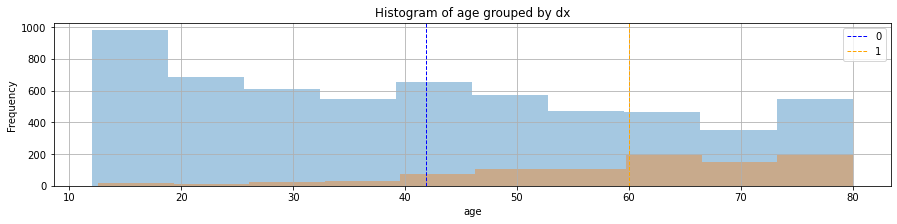

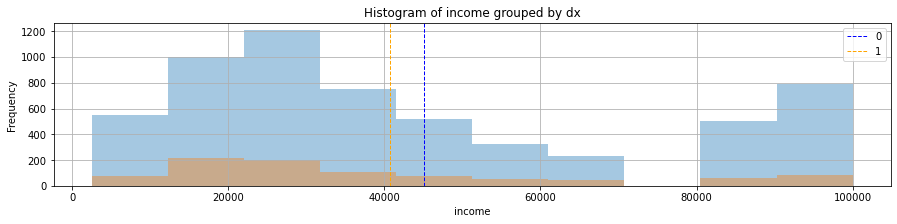

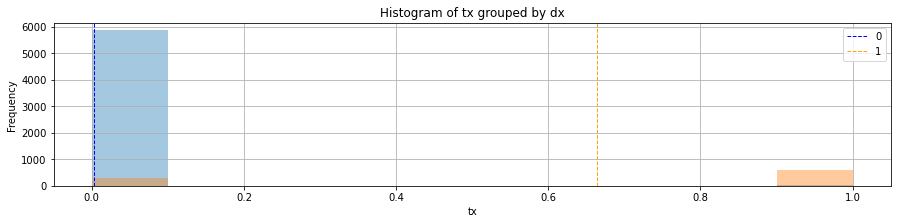

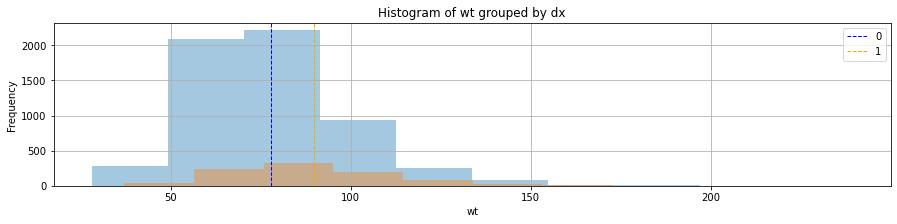

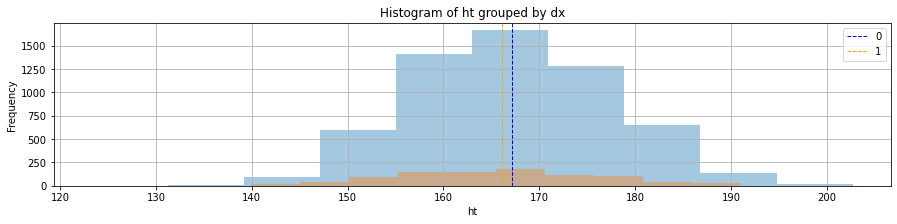

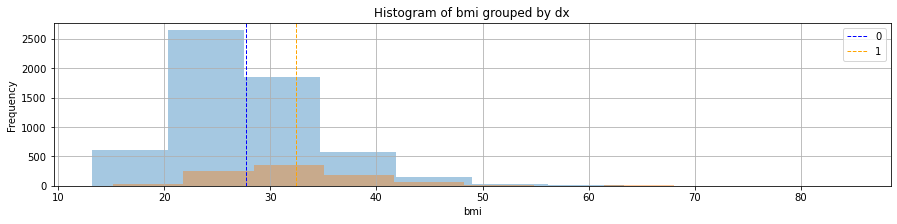

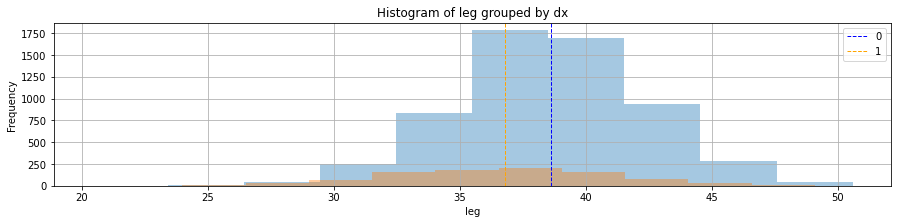

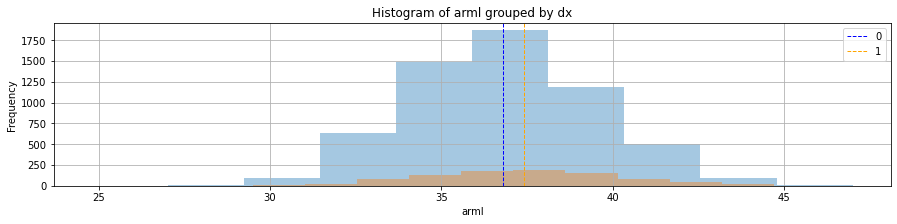

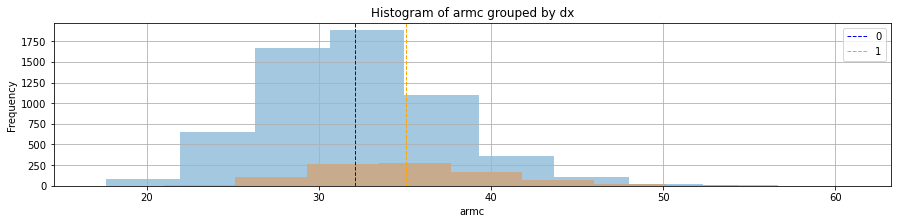

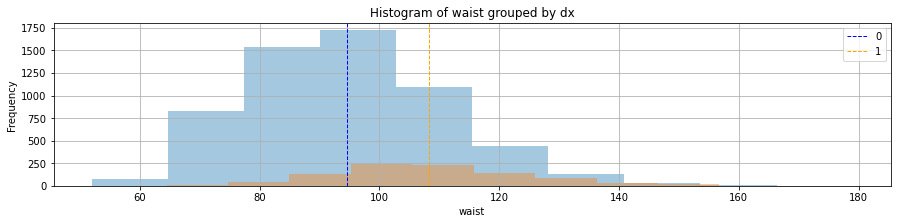

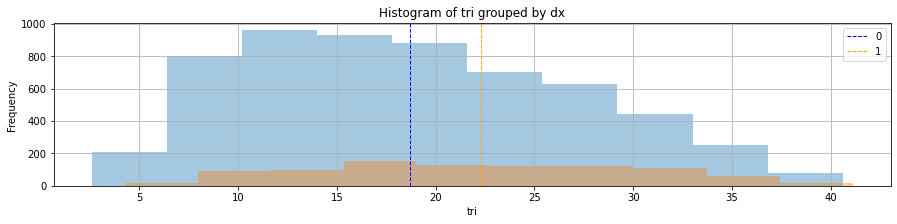

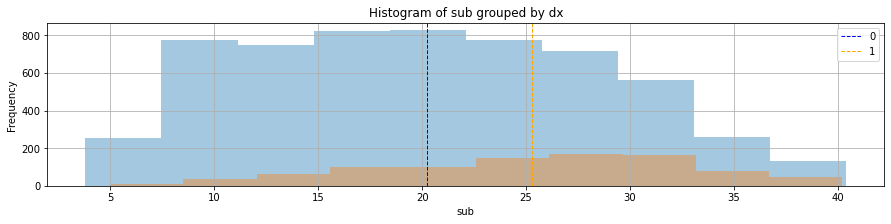

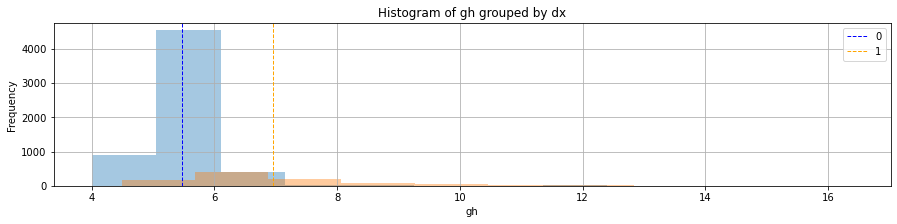

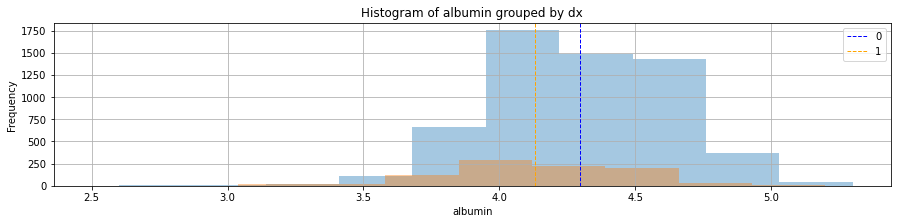

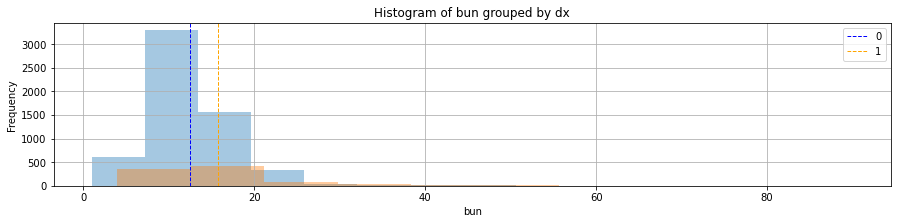

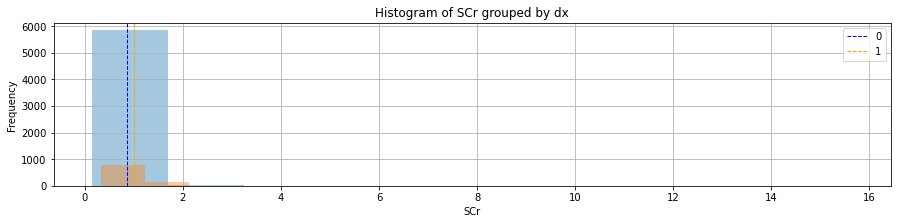

In [3]:
#'dx' is the target column
target = 'dx'

# Get list of columns in DataFrame
columns = data_nonull.columns.tolist()

# Remove the target and re from the list of columns
columns.remove(target)
columns.remove('re') #non-numerical column

# For each column, plot a histogram grouped by the target
for column in columns:
    plt.figure(figsize=(15,3))
    data_nonull.groupby(target)[column].hist(alpha=0.4)
    if type(data_nonull[column][0]) != str:
        plt.axvline(data_nonull.groupby(target)[column].mean()[0], color='b', linestyle='dashed', linewidth=1)
        plt.axvline(data_nonull.groupby(target)[column].mean()[1], color='orange', linestyle='dashed', linewidth=1)
    plt.title('Histogram of {} grouped by {}'.format(column, target))
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(data_nonull[target].unique())
    plt.show()

<b>Summary of Histograms</b>

Based on the distribution of the frequency of values for features and the closeness of the means, [seqn, sex_male, income, ht, arml, SCr] seems to be poor predictors for our target as the mean and distribution of both positive and negative classes are similar.

[age, waist, tri, sub, gh], conversely, are some strong predictors for the target as the means for the two populations are very different.

However, since the values are not normalised, the differences of some of the values might be too small to see. Thus, we will have to verify the strength of the correlation of all features with the target to see if it concurs with the above observations.


<h4>Distribution across Races</h4>

In [4]:
#Querying from nhgh_nonull database
re_compare = pd.read_sql(
    '''
    SELECT dx, re
    FROM nhgh_nonull
    ''',
    sqliteConnection
)
re_compare.head()

,dx,re
0,0,Non-Hispanic White
1,0,Non-Hispanic Black
2,1,Non-Hispanic Black
3,0,Mexican American
4,0,Non-Hispanic White


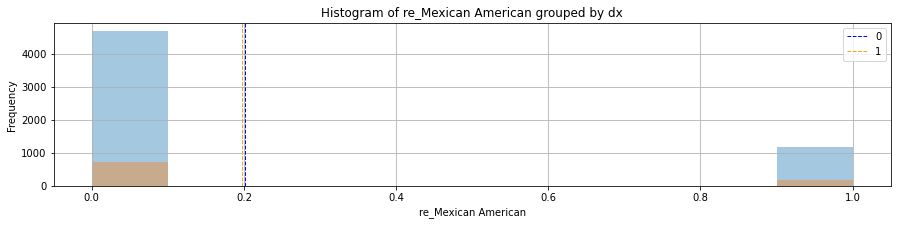

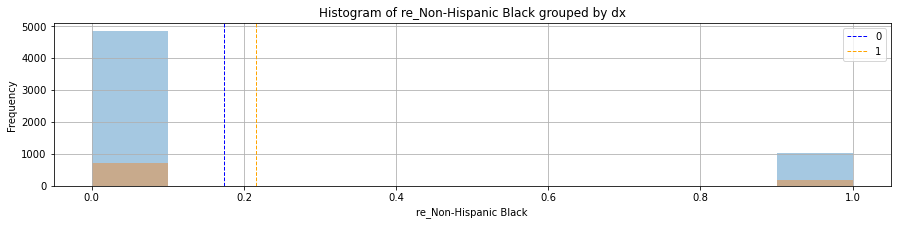

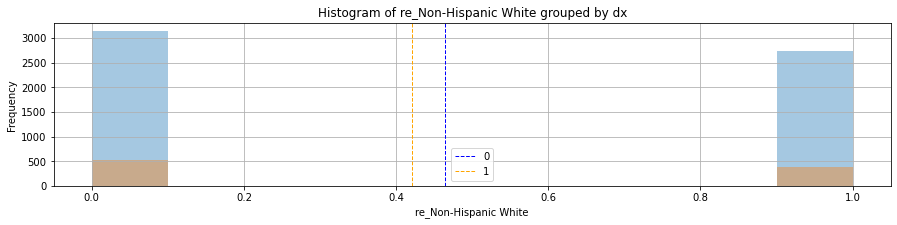

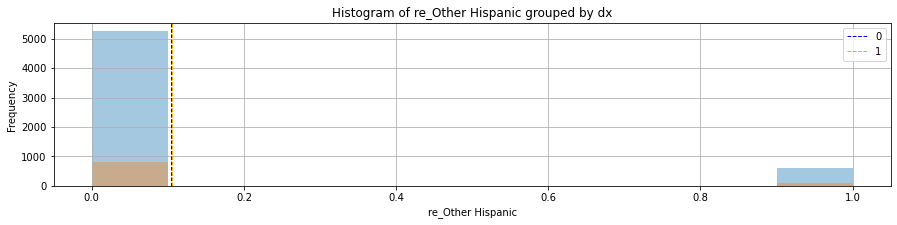

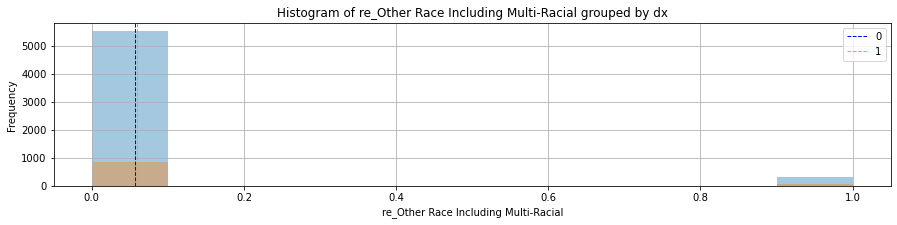

In [5]:
re_compare = pd.get_dummies(re_compare, columns=['re'], drop_first = False)
re_compare

column_re = re_compare.columns.tolist()
column_re.remove(target)

# For each column, plot a histogram grouped by the target
for column in column_re:
    plt.figure(figsize=(15,3))
    re_compare.groupby(target)[column].hist(alpha=0.4)
    if type(re_compare[column][0]) != str:
        plt.axvline(re_compare.groupby(target)[column].mean()[0], color='b', linestyle='dashed', linewidth=1)
        plt.axvline(re_compare.groupby(target)[column].mean()[1], color='orange', linestyle='dashed', linewidth=1)
    plt.title('Histogram of {} grouped by {}'.format(column, target))
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(re_compare[target].unique())
    plt.show()

Similar to the findings of the previous section, [re] seems to be a poor predictor for our target as the mean and distribution of both positive and negative targets are similar. This will be verified when measuring the strength of the correlation to target.

<h4>Distribution of Positive vs. Negative Classes</h4>

Text(0, 0.5, 'Frequency')

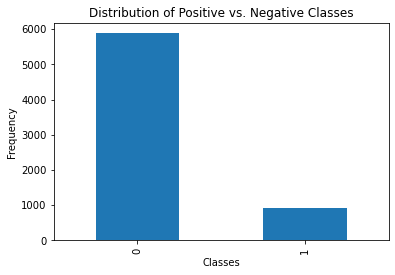

In [6]:
#Querying from nhgh_nonull database
dx_compare = pd.read_sql(
    '''
    SELECT dx
    FROM nhgh_nonull
    ''',
    sqliteConnection
)
dx_compare.value_counts().plot(kind='bar', title="Distribution of Positive vs. Negative Classes", use_index = False)
plt.xlabel('Classes')
plt.ylabel('Frequency')

From the distribution, it is noted that there is an imbalance in terms of the numbers of samples between the positive vs. the negative classes. Thus, techniques need to be employed when building the model to address this.

## Feature Selection/Engineering

### Dropping of [tx]

One thing to note is that the distribution and means for [tx] (On Insulin or Diabetes Meds) is markedly different and hence should be a prime candidate for a strong predictor for diabetes. However, one diabetic medication, metformin, can be prescribed as a weight loss medication (https://www.ccjm.org/content/90/9/545) and for other purposes (https://www.health.harvard.edu/blog/is-metformin-a-wonder-drug-202109222605), which can be a red herring to our model's prediction.

Furthermore, predicting if a patient has diabetes would be done prior to his/her diagnosis and hence, he/she would not have been prescribed any medication in the first place. If [tx] were to be used in our model, there is a high likelihood that the model predicts a high proportion of False Negatives (because the patient, although diabetic, has yet to be diagnosed and is not under medication), which severely undermines the intent of this model. Thus, [tx] will be dropped as a feature.

In [7]:
data_model = data_nonull.drop(columns='tx')
data_model.head()

,seqn,sex_male,age,re,income,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
0,51624,1.0,34.166667,Non-Hispanic White,30000.0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
1,51626,1.0,16.833333,Non-Hispanic Black,50000.0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
2,51628,0.0,60.166667,Non-Hispanic Black,12500.0,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
3,51629,1.0,26.083333,Mexican American,30000.0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
4,51630,0.0,49.666667,Non-Hispanic White,40000.0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79


### Feature Correlation


<h4>Overall</h4>

In [8]:
#Dummyfying re column

data_model = pd.get_dummies(data_model, columns=['re'], drop_first = True)
data_model

,seqn,sex_male,age,income,dx,wt,ht,bmi,leg,arml,...,tri,sub,gh,albumin,bun,SCr,re_Non-Hispanic Black,re_Non-Hispanic White,re_Other Hispanic,re_Other Race Including Multi-Racial
0,51624,1.0,34.166667,30000.0,0,87.4,164.7,32.22,41.5,40.0,...,16.4,24.9,5.2,4.8,6.0,0.94,0,1,0,0
1,51626,1.0,16.833333,50000.0,0,72.3,181.3,22.00,42.0,39.5,...,10.2,10.5,5.7,4.6,9.0,0.89,1,0,0,0
2,51628,0.0,60.166667,12500.0,1,116.8,166.0,42.39,35.3,39.0,...,29.6,35.6,6.0,3.9,10.0,1.11,1,0,0,0
3,51629,1.0,26.083333,30000.0,0,97.6,173.0,32.61,41.7,38.7,...,19.0,23.2,5.1,4.2,8.0,0.80,0,0,0,0
4,51630,0.0,49.666667,40000.0,0,86.7,168.4,30.57,37.5,36.1,...,30.3,28.0,5.3,4.3,13.0,0.79,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,62155,1.0,33.000000,40000.0,0,94.3,163.5,35.28,34.4,34.7,...,20.2,28.5,5.4,4.1,10.0,0.97,0,0,0,0
6791,62156,0.0,48.916667,2500.0,1,87.1,156.9,35.38,33.9,34.5,...,28.6,25.4,5.5,4.1,7.0,0.89,0,1,0,0
6792,62157,1.0,27.500000,40000.0,0,57.0,164.3,21.12,35.3,33.7,...,4.2,6.8,5.6,4.5,11.0,0.94,0,0,1,0
6793,62158,1.0,75.750000,12500.0,0,75.1,162.7,28.37,38.6,36.8,...,19.8,21.1,5.4,4.0,19.0,1.34,1,0,0,0


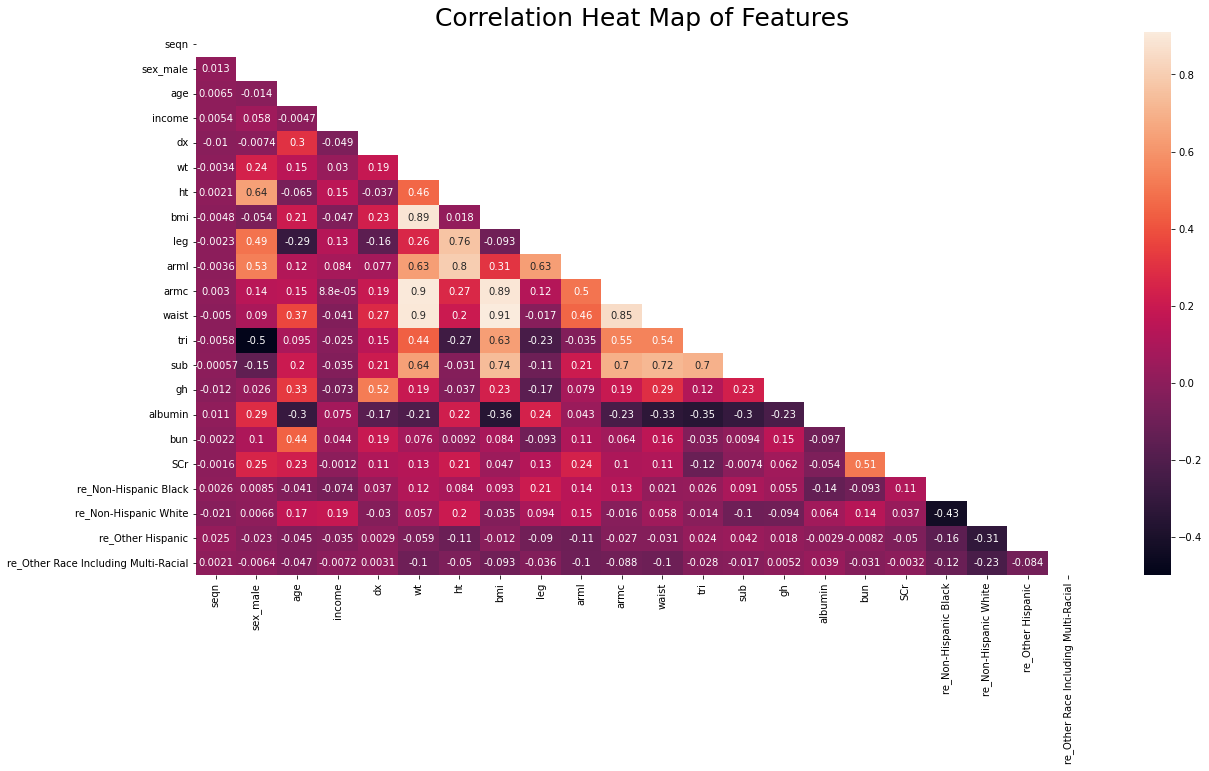

In [9]:
#Plotting the correlation heatmap
plt.figure(figsize = [20,10])
matrix = np.triu(data_model.corr())
sns.heatmap(data_model.corr(), annot=True, mask=matrix);
plt.title('Correlation Heat Map of Features', size = 25);

From the overall correlation heat map of all the features, we see that the previously identified poor and good predictors relates highly to the correlation strength to the target.

<u>Poor (expected to be close to 0)</u>
- seqn: -0.01
- sex_male: -0.0074
- income: -0.0047
- ht: -0.037
- arml: 0.077
- SCr: 0.11 
- re_Non-Hispanic Black: 0.037
- re_Non-Hispanic White: -0.03
- re_Other Hispanic: 0.0029
- re_Other Race Including Multi-Racial: 0.0031

<u>Good (expected to be close to 1 or -1)</u>
- age: 0.3
- waist: 0.27
- tri: 0.15
- sub: 0.21
- gh: 0.52

However, there are also other highly correlated features pairwise (i.e. to each other) which suggest collinearity between features. Collinearity refers to a situation where two or more predictor variables are closely related to one another and this will affect the performance and interpretability of the model (which has an inate basis that variables are all independent).


<h4>Feature Selection based on Correlation to Target</h4>

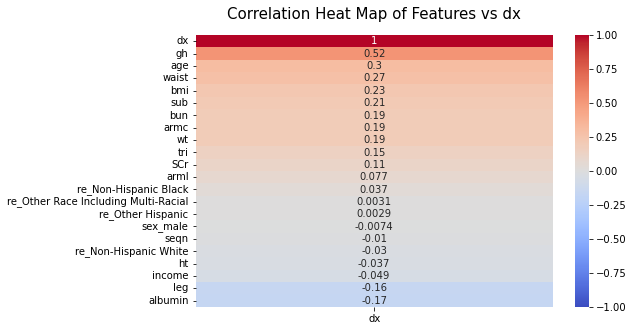

In [10]:
#Extracting the correlation heatmap to target only
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(data_model.corr()[['dx']].sort_values(by='dx', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heat Map of Features vs dx', fontdict={'fontsize':15}, pad=16);

I will be dropping poorly correlated features with values that are less than |0.15| for the model.

In [11]:
drop_col = data_model.corr()[['dx']][(data_model.corr()['dx'] > -0.15) & (data_model.corr()['dx']< 0.15)].index.tolist()
data_model = data_model.drop(columns=drop_col)
data_model.head()

,age,dx,wt,bmi,leg,armc,waist,sub,gh,albumin,bun
0,34.166667,0,87.4,32.22,41.5,36.4,100.4,24.9,5.2,4.8,6.0
1,16.833333,0,72.3,22.00,42.0,26.6,74.7,10.5,5.7,4.6,9.0
2,60.166667,1,116.8,42.39,35.3,42.2,118.2,35.6,6.0,3.9,10.0
3,26.083333,0,97.6,32.61,41.7,37.0,103.7,23.2,5.1,4.2,8.0
4,49.666667,0,86.7,30.57,37.5,33.3,107.8,28.0,5.3,4.3,13.0


<h4>Feature Selection based on Pairwise Collinearity of Features</h4>

In [12]:
#making the features correlation matrix
feature_corr = data_model.corr()
dx_corr = feature_corr[['dx']]

#dropping dx from the features df
feature_corr.drop(columns = 'dx', axis = 1, inplace=True)
feature_corr.drop('dx', axis = 0, inplace=True)

#pulling out column names
feature_list = feature_corr.columns.values.tolist()
pairwise_corr = []

#making a new dataframe of pairwise corr and attaching corr to saleprice
for first, second in combinations(feature_list, 2):
    corr_num = feature_corr.loc[first,second]
    first_sp_corr = dx_corr.loc[first, 'dx']
    second_sp_corr = dx_corr.loc[second, 'dx']
    pairwise_corr.append(pd.DataFrame([{'pair_corr': corr_num, 'dx_corr_1': first_sp_corr, 'dx_corr_2': second_sp_corr}], index=[str(first)+ ' vs. ' + str(second)], columns=['pair_corr', 'dx_corr_1', 'dx_corr_2']))
    
pairwise_corr_df = pd.concat(pairwise_corr)
pairwise_corr_df.sort_values('pair_corr', ascending=False).head(5)

,pair_corr,dx_corr_1,dx_corr_2
bmi vs. waist,0.910655,0.232171,0.274979
wt vs. armc,0.904446,0.187924,0.189692
wt vs. waist,0.897200,0.187924,0.274979
bmi vs. armc,0.891482,0.232171,0.189692
wt vs. bmi,0.887547,0.187924,0.232171


The top 5 highest pairwise correlation pairings are a mix between the same 4 features: [bmi, waist, wt, armc]. This is to be expected as these body measurements are dependant on the body fat percentage of the patient. One of the features alone should be be able to adequately describe for the other redundant measurements. Thus, [waist] will be chosen as it has the highest correlation to the target.


In [13]:
drop_col2 = ['bmi', 'wt', 'armc']
data_model = data_model.drop(columns=drop_col2)
data_model.head()

,age,dx,leg,waist,sub,gh,albumin,bun
0,34.166667,0,41.5,100.4,24.9,5.2,4.8,6.0
1,16.833333,0,42.0,74.7,10.5,5.7,4.6,9.0
2,60.166667,1,35.3,118.2,35.6,6.0,3.9,10.0
3,26.083333,0,41.7,103.7,23.2,5.1,4.2,8.0
4,49.666667,0,37.5,107.8,28.0,5.3,4.3,13.0


In [14]:
data_model.columns.to_list()

['age', 'dx', 'leg', 'waist', 'sub', 'gh', 'albumin', 'bun']